In [28]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [29]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import warnings
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix)
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import numpy as np
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [30]:
df = pd.read_csv('C:\DMPA Project\RTA Dataset.csv')
column = df.columns

cat_columns = [colname for colname in df.select_dtypes(["object", "category"])]
len(cat_columns)

30

In [31]:
df.describe(include='object')

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
count,12316,12316,12316,12316,11575,11737,11487,11366,11834,8388,...,12008,12316,12316,12316,12316,9118,9681,12316,12316,12316
unique,1074,7,5,3,7,4,7,17,4,6,...,13,4,3,6,4,7,5,9,20,3
top,15:30:00,Friday,18-30,Male,Junior high school,Employee,5-10yr,Automobile,Owner,Unknown,...,Going straight,Driver or rider,Male,na,3,Driver,Normal,Not a Pedestrian,No distancing,Slight Injury
freq,120,2041,4271,11437,7619,9627,3363,3205,10459,2883,...,8158,4944,5253,4443,7076,5903,9608,11390,2263,10415


In [32]:
df.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


In [33]:
import random

def random_palette():
    """
    Create a random palette each every time
    """
    base_palette = sns.color_palette("pastel", 5) + sns.color_palette("tab20c", 5) + sns.color_palette("tab20b", 5)
    colour_list = random.sample(base_palette, 5)
    palette = sns.blend_palette([colour for colour in colour_list], 10)
    return palette

In [34]:
def subplot(df, i, column, order=None, pallete=random_palette()):
    plt.subplot(2, 3 ,i)
    sns.barplot(data=df[column].value_counts().reset_index(), x = column, y = 'count', palette=random_palette(), order=order)
    plt.xticks(rotation=45)


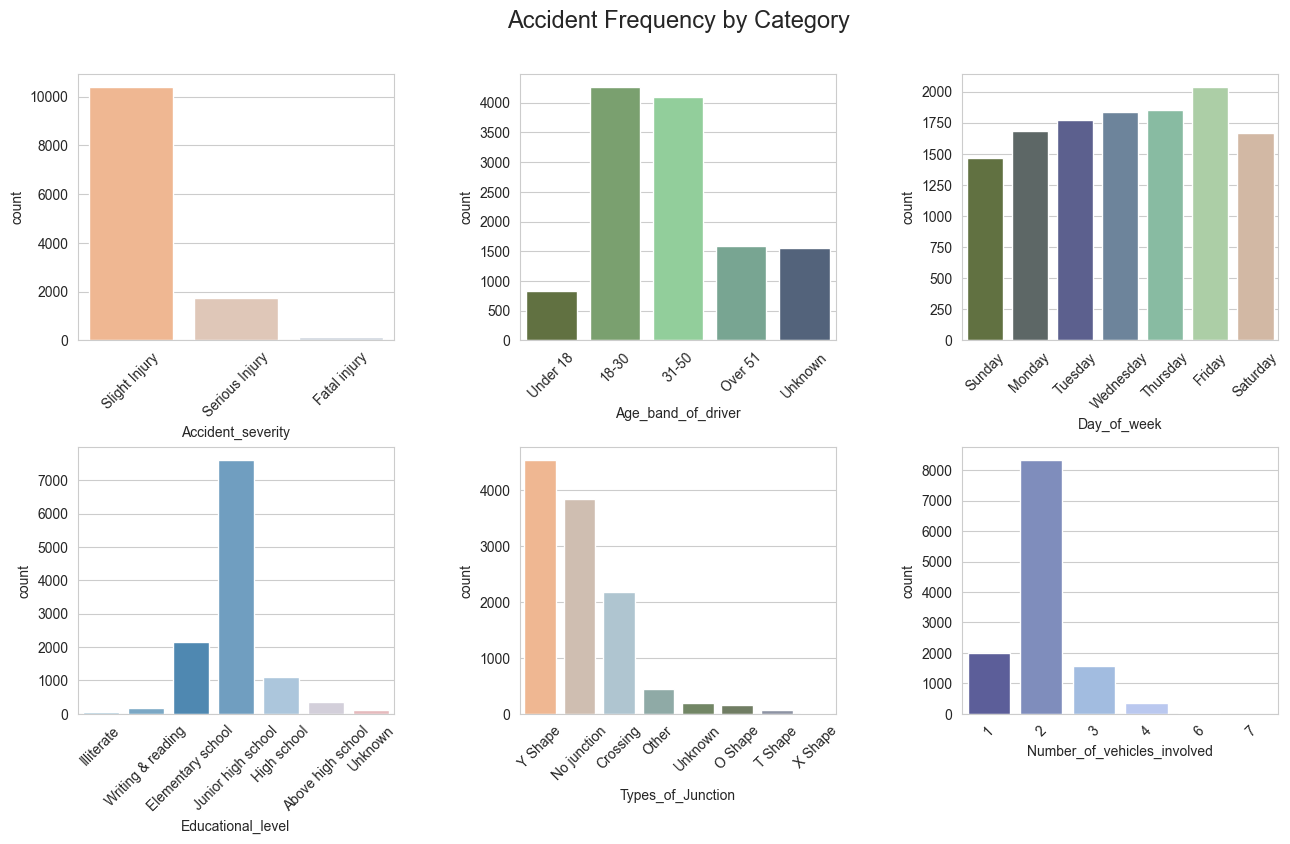

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 8))
plt.suptitle("Accident Frequency by Category", fontsize=17)

subplot(df, i=1, column = 'Accident_severity')

age_order = ['Under 18', '18-30', '31-50', 'Over 51', 'Unknown']
subplot(df, i=2, column = 'Age_band_of_driver', order= age_order)

day_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
subplot(df, i=3, column = 'Day_of_week', order=day_order)

education_order= ["Illiterate", "Writing & reading", "Elementary school", "Junior high school","High school","Above high school","Unknown"]
subplot(df, i=4, column = 'Educational_level', order=education_order)

subplot(df, i=5, column = 'Types_of_Junction')
subplot(df, i=6, column = 'Number_of_vehicles_involved')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [36]:
def fatality_df(column, df=df, sort=False):
    """
    fetches a dataframe having category wise fatality frequency
    """
    df_hello = df.groupby(['Accident_severity', column]).Time.count().reset_index()

    rowlist = [row for row in df_hello[column]]
    sumlist = []
    for row in rowlist:
        sumlist.append(df_hello.loc[df_hello[column] == row].Time.sum())

    df_hello['sum'] = sumlist
    df_hello['ratio'] = df_hello['Time']/df_hello['sum']
    df_final = df_hello.loc[df_hello.Accident_severity=='Fatal injury']
    if sort==True:
        df_final = df_final.sort_values(by='ratio')
    return df_final

# example
fatal_collisiontype_df = fatality_df('Type_of_collision', sort=True)
fatal_collisiontype_df

,Accident_severity,Type_of_collision,Time,sum,ratio
3,Fatal injury,Rollover,4,397,0.010076
0,Fatal injury,Collision with animals,2,171,0.011696
4,Fatal injury,Vehicle with vehicle collision,104,8774,0.011853
2,Fatal injury,Collision with roadside objects,24,1786,0.013438
1,Fatal injury,Collision with pedestrians,22,896,0.024554


In [37]:
def fatal_palette(df, positions_to_change: list):

    palette = ['#96898b']*df.shape[0]
    new_values = ['#cc253b']*len(positions_to_change)
    for position, new_value in zip(positions_to_change, new_values):
        palette[position] = new_value
    return sns.color_palette(palette)

In [38]:
def fatal_plot(i, column, red_list, order=None, custom_labels=None, subplot=True, sort=False):
    """
    Plot charts using the fatality_df and fatal_palette. 
    Used to plot values in a column against the fatality frequency.  
    """
    if subplot==True:
        plt.subplot(2, 3 ,i)
    sns.barplot(data=fatality_df(column, sort=sort), x=column, y='ratio', palette=fatal_palette(fatality_df(column, sort=sort), red_list), order=order)
    
    if custom_labels is not None:
        xtick_positions = plt.xticks()[0]
        plt.xticks(xtick_positions, custom_labels)
        
    plt.xticks(rotation=45)
    plt.xlabel(column, fontsize= 14).set_color('#425169')
    plt.ylabel('Fatality ratio', fontsize= 14).set_color('#425169')
    ax = plt.gca()
    ax.spines[['bottom', 'left', 'top', 'right']].set_color('#425169')
    ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(1)

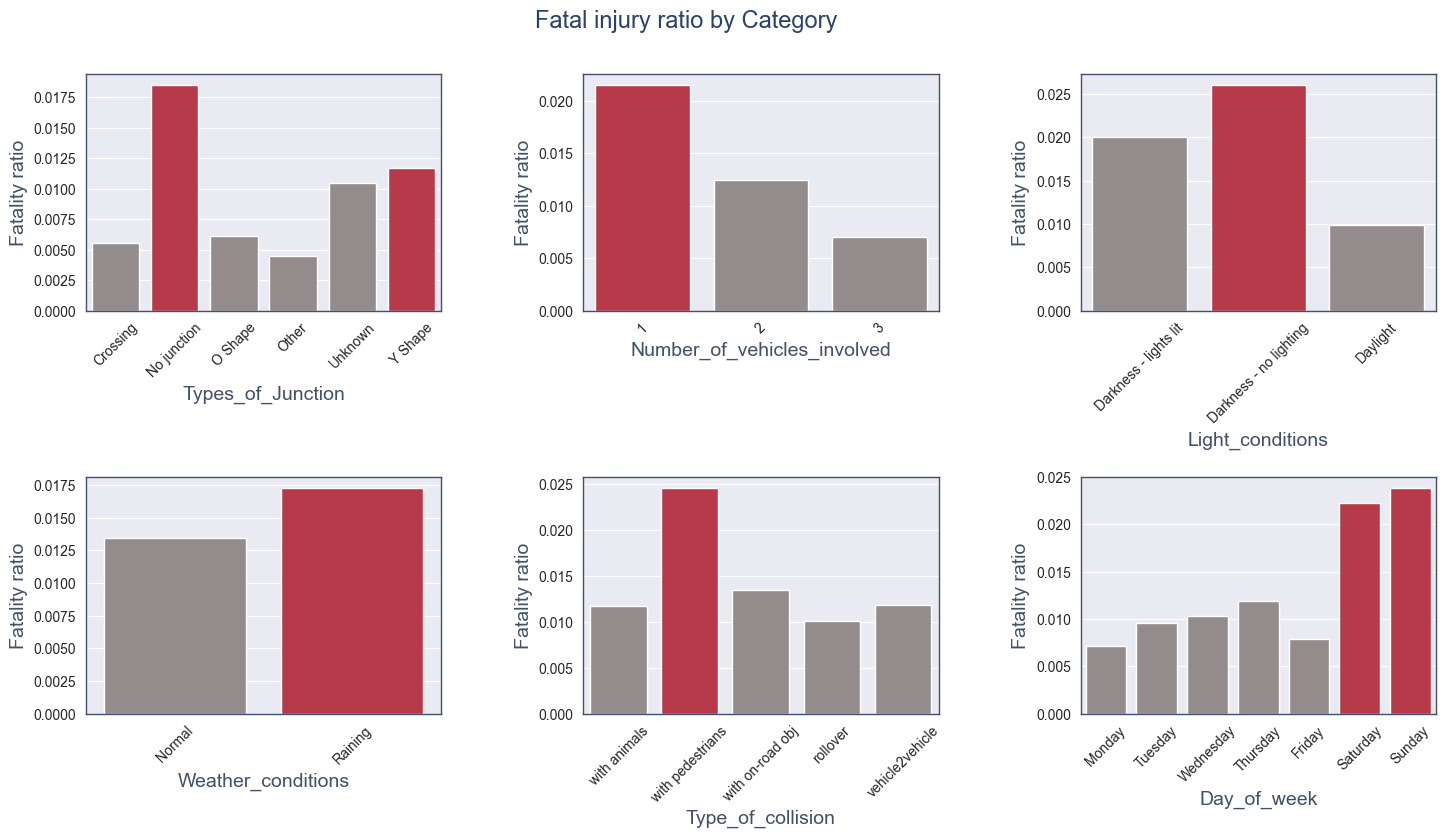

In [39]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 8))
plt.suptitle("Fatal injury ratio by Category", fontsize=17).set_color('#2c4369')

fatal_plot(1, 'Types_of_Junction', [1, 5])
fatal_plot(2, 'Number_of_vehicles_involved', [0])
fatal_plot(3, 'Light_conditions', [1])
fatal_plot(4, 'Weather_conditions', [1])
fatal_plot(5, 'Type_of_collision', [1], custom_labels = ['with animals', 'with pedestrians', 'with on-road obj', 'rollover', 'vehicle2vehicle'])
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
fatal_plot(6, 'Day_of_week', [-1, -2], order=day_order)

plt.subplots_adjust(left=0.1, right=1, bottom=0.1, top=0.9, wspace=0.4, hspace=0.7)
plt.show()

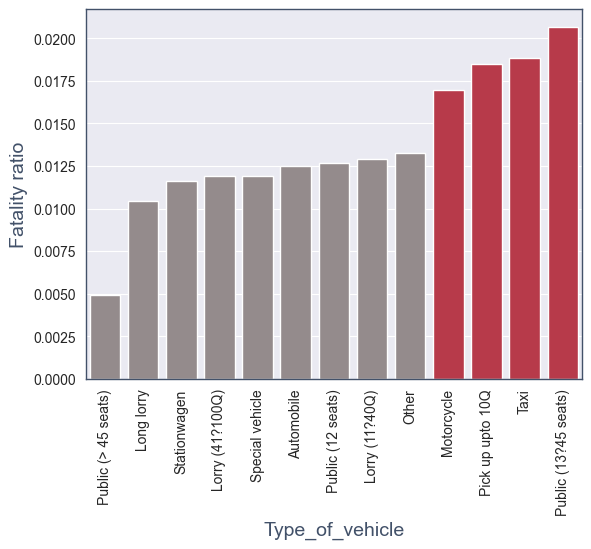

In [40]:
fatal_plot(1, 'Type_of_vehicle', [-1, -2, -3, -4], subplot=False, sort=True)
plt.xticks(rotation=90)
plt.show()

In [41]:
def crossdf(col):
    """
    Return a pandas crosstab for the given column against the target variable
    """
    crossdf = pd.crosstab(df['Accident_severity'], df[col], normalize='index')
    crossdf = crossdf.reset_index()
    return crossdf

df1 = crossdf('Sex_of_driver')
df1

Sex_of_driver,Accident_severity,Female,Male,Unknown
0,Fatal injury,0.031646,0.962025,0.006329
1,Serious Injury,0.059667,0.930006,0.010327
2,Slight Injury,0.056841,0.927892,0.015266


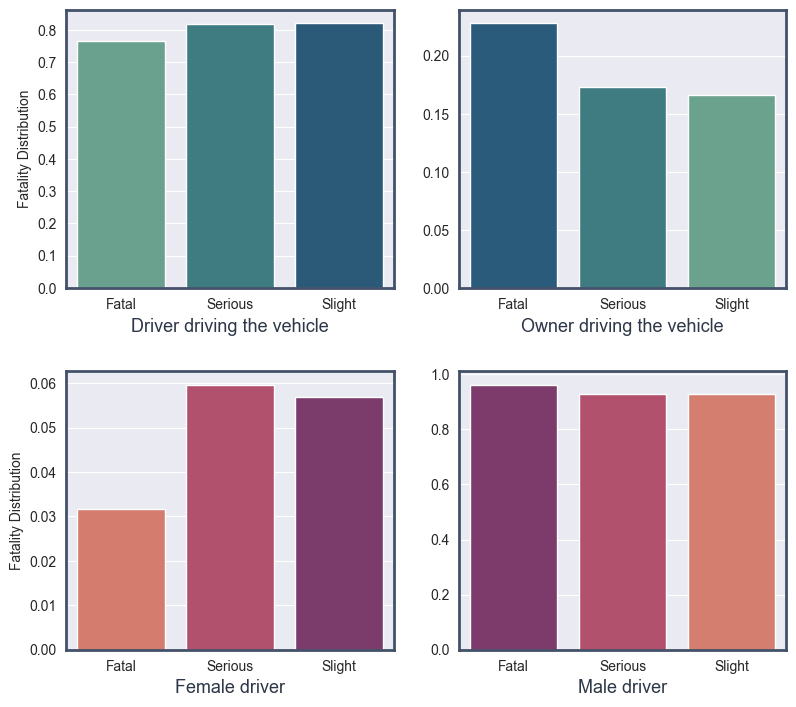

In [42]:
plt.figure(figsize=(8, 8))
custom_labels = ['Fatal', 'Serious', 'Slight']

plt.subplot(2, 2, 1)
sns.barplot(data = crossdf('Vehicle_driver_relation'),  x = 'Accident_severity', y = 'Employee', palette = 'crest')
plt.xlabel('Driver driving the vehicle', fontsize= 13).set_color('#2d3747')
plt.ylabel('Fatality Distribution')

xtick_positions = plt.xticks()[0]
plt.xticks(xtick_positions, custom_labels)
ax = plt.gca()
ax.spines[['bottom', 'left', 'top', 'right']].set_color('#425169')
ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(2)   


plt.subplot(2, 2, 2)
sns.barplot(data = crossdf('Vehicle_driver_relation'),  x = 'Accident_severity', y = 'Owner', palette = 'crest_r')
plt.xlabel('Owner driving the vehicle', fontsize= 13).set_color('#2d3747')
plt.ylabel('')

xtick_positions = plt.xticks()[0]
plt.xticks(xtick_positions, custom_labels)
ax = plt.gca()
ax.spines[['bottom', 'left', 'top', 'right']].set_color('#425169')
ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(2)


plt.subplot(2, 2, 3)
sns.barplot(data = crossdf('Sex_of_driver'),  x = 'Accident_severity', y = 'Female', palette = 'flare')
plt.xlabel('Female driver', fontsize= 13).set_color('#2d3747')
plt.ylabel('Fatality Distribution')

xtick_positions = plt.xticks()[0]
plt.xticks(xtick_positions, custom_labels)
ax = plt.gca()
ax.spines[['bottom', 'left', 'top', 'right']].set_color('#425169')
ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(2)

plt.subplot(2, 2, 4)
sns.barplot(data = crossdf('Sex_of_driver'),  x = 'Accident_severity', y = 'Male', palette = 'flare_r')
plt.xlabel('Male driver', fontsize= 13).set_color('#2d3747')
plt.ylabel('')

xtick_positions = plt.xticks()[0]
plt.xticks(xtick_positions, custom_labels)
ax = plt.gca()
ax.spines[['bottom', 'left', 'top', 'right']].set_color('#425169')
ax.spines[['bottom', 'left', 'top', 'right']].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=1, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

In [43]:
columns_to_drop = ['Fitness_of_casuality', 'Service_year_of_vehicle', 'Defect_of_vehicle']
df_dropped = df.drop(columns=columns_to_drop)

df_dropped.replace('unknown', 'Unknown', inplace=True)
df_dropped.Work_of_casuality = df_dropped.Work_of_casuality.fillna('Unknown') 

columns_with_unknown = df_dropped.columns[df_dropped.isin(['Unknown']).any()]
for column in columns_with_unknown:
    df_dropped[column] = df_dropped[column].fillna('Unknown')

for column in df_dropped.columns:
    mode_value = df_dropped[column].mode()[0]
    df_dropped[column].fillna(mode_value, inplace=True)

In [44]:
df_dropped['Time'] = pd.to_datetime(df_dropped['Time'])
df_dropped['Time'] = df_dropped['Time'].dt.strftime('%H:%M:%S')

df_dropped['Time'] = df_dropped['Time'].str.split(':').str[0].astype(int)
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df_dropped['Time'] = pd.cut(df_dropped['Time'], bins=bins, labels=labels, right=False)

In [45]:
all_columns = df_dropped.columns.tolist()
ordinal_columns = ['Time', 'Day_of_week', 'Age_band_of_driver', 'Educational_level', 'Driving_experience', 'Light_conditions', 'Age_band_of_casualty', 'Casualty_severity']
label_columns = [col for col in all_columns if col not in ordinal_columns]
columns_to_remove = ['Number_of_casualties', 'Number_of_vehicles_involved']
label_columns = [col for col in label_columns if col not in columns_to_remove]

In [46]:
from sklearn.preprocessing import LabelEncoder

def encode_columns(df, label_encode_columns=None, ordinal_encode_columns=None):
    """
    Encode specified columns in a DataFrame using label encoding and ordinal encoding.
    Returns:
        pd.DataFrame: A copy of the DataFrame with specified columns encoded.
    """
    encoded_df = df.copy()
    
    if label_encode_columns:
        label_encoder = LabelEncoder()
        for column in label_encode_columns:
            encoded_df[column] = label_encoder.fit_transform(encoded_df[column])
    
    if ordinal_encode_columns:
        for column, category_order in ordinal_encode_columns.items():
            category_mapping = {category: index for index, category in enumerate(category_order)}
            encoded_df[column] = encoded_df[column].map(category_mapping)
    
    return encoded_df


In [47]:
label_encode_cols = label_columns
ordinal_encode_cols = {'Time': ['Morning', 'Afternoon', 'Evening', 'Night'],'Day_of_week': ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'], 'Age_band_of_driver': ['Unknown', 'Under 18', '18-30', '31-50', 'Over 51'], 'Educational_level': ["Unknown", "Illiterate", "Writing & reading", "Elementary school", "Junior high school","High school","Above high school"], 'Driving_experience': ['Unknown', 'No Licence', 'Below 1yr', '1-2yr', '2-5yr', '5-10yr', 'Above 10yr'], 'Light_conditions': ['Darkness - no lighting', 'Darkness - lights unlit', 'Darkness - lights lit', 'Daylight'], 'Age_band_of_casualty': ['na', '5', 'Under 18', '18-30', '31-50', 'Over 51'], 'Casualty_severity': ['na', '1', '2', '3']}

df_ord = encode_columns(df_dropped, label_encode_columns=label_encode_cols, ordinal_encode_columns=ordinal_encode_cols)
df_ord['Time'] = df_ord['Time'].astype(int)
df_ord['Driving_experience'] = df_ord['Driving_experience'].astype(int)

df_ord.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,1,1,2,1,6,0,3,0,3,9,...,2,2,3,2,0,0,6,5,9,2
1,1,1,3,1,4,0,6,11,3,6,...,2,2,3,2,0,0,6,5,16,2
2,1,1,2,1,4,0,3,5,3,1,...,2,2,0,1,4,3,0,5,0,1
3,3,0,2,1,4,0,5,11,0,6,...,2,2,2,0,3,3,0,5,1,2
4,3,0,2,1,4,0,4,0,3,4,...,2,2,3,2,0,0,6,5,16,2


In [48]:
# splitting df_ord
X = df_ord.drop('Accident_severity', axis=1)
y = df_ord['Accident_severity']

Xord_train, Xord_test, yord_train, yord_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(Xord_train.shape, Xord_test.shape, yord_train.shape, yord_test.shape)

(9852, 28) (2464, 28) (9852,) (2464,)


In [49]:
train, test = train_test_split(df_ord, test_size=0.2, random_state=42, stratify=df_ord['Accident_severity'])
print(train.shape, test.shape)

(9852, 29) (2464, 29)


In [50]:
columns_to_include = df_dropped.columns.tolist()
values_to_remove = ['Accident_severity', 'Number_of_casualties', 'Number_of_vehicles_involved', 'Casualty_severity', 'Age_band_of_casualty', 'Light_conditions', 'Driving_experience', 'Educational_level', 'Age_band_of_driver', 'Day_of_week', 'Time']
for value in values_to_remove:    
    columns_to_include.remove(value)

In [51]:
def mean_encode(train, test, columns_to_include):
    # mean encoding
    df_mean = train.copy()
    df_mean_test = test.copy()
    for col in columns_to_include:
        category_means = df_mean.groupby(col)['Accident_severity'].mean().to_dict()
        df_mean[col] = df_mean[col].map(category_means)
        df_mean_test[col] = df_mean_test[col].map(category_means)

    df_mean['Time'] = df_mean['Time'].astype(int)
    df_mean_test['Time'] = df_mean_test['Time'].astype(int)
    for column in df_mean_test.columns:
        mode_value = df_mean_test[column].mode()[0]
        df_mean_test[column].fillna(mode_value, inplace=True)
    return df_mean, df_mean_test
mean_train, mean_test = mean_encode(train, test, columns_to_include)    
mean_train.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,...,Number_of_casualties,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
6068,0,1,0,1.831273,4,1.836437,4,1.856743,1.831884,1.825641,...,1,1.836469,1.826186,1.837595,4,2,1.827156,1.833883,1.847007,2
5981,1,0,2,1.831273,4,1.836437,5,1.814371,1.831884,1.840778,...,1,1.836469,1.828635,1.837595,3,2,1.841883,1.827586,1.812918,2
10572,2,5,2,1.831273,3,1.836437,5,1.826353,1.831884,1.835248,...,1,1.843792,1.827893,1.837595,4,2,1.827156,1.833883,1.816344,1
4862,2,0,2,1.831273,3,1.836437,3,1.789474,1.831884,1.846715,...,1,1.827715,1.826186,1.821658,3,3,1.836100,1.833883,1.826268,2
5016,1,4,0,1.831273,4,1.836437,5,1.826353,1.831884,1.802639,...,2,1.836469,1.826186,1.821658,3,3,1.836100,1.833883,1.841226,2


In [52]:
# splitting (df_mean) mean_train and mean_test
Xmean_train = mean_train.drop('Accident_severity', axis=1)
ymean_train = mean_train['Accident_severity']

Xmean_test= mean_test.drop('Accident_severity', axis=1)
ymean_test = mean_test['Accident_severity']
print(Xmean_train.shape, Xmean_test.shape, ymean_train.shape, ymean_test.shape)

(9852, 28) (2464, 28) (9852,) (2464,)


In [53]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    bvd = {}
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb'] = f1_score(y_test, y_pred, average='micro')
        models.append(xgb)


    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf'] = f1_score(y_test, y_pred, average='micro')
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = f1_score(y_test, y_pred, average='micro')
        models.append(extree)
        
    return scores,models

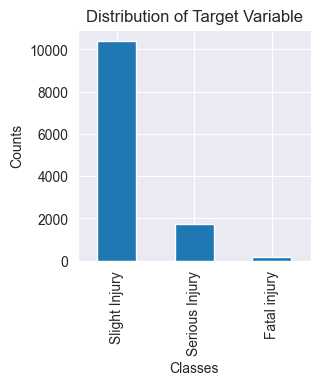

In [54]:
target_counts = df["Accident_severity"].value_counts()

plt.figure(figsize=(3, 3))
target_counts.plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [55]:

def upsample(tech, X_train, y_train):
    counter = Counter(y_train)

    for k,v in counter.items():
        per = 100*v/len(y_train)
        
    if tech == 'smote':
        oversample = SMOTE(random_state=42)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    elif tech =='smotet':
        smt = SMOTETomek(random_state=42)
        X_train, y_train = smt.fit_resample(X_train, y_train)
        
    counter = Counter(y_train)


    for k,v in counter.items():
        per = 100*v/len(y_train)

    return X_train, y_train 

In [56]:
def upsample_train(tech, X_train, X_test, y_train, y_test): 
    """
    Performs upsampling and modelling over the data given
    Args: 
        tech (str): techinque by which to perform upsampling. SMOTE or SMOTETomek
    """
    X_train,y_train = upsample(tech, X_train, y_train)
    print('')
    scores,models = modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)
    print(scores)
    return scores, models

In [58]:
# mean + label with smote
upsample_train('smote', Xmean_train, Xmean_test, ymean_train, ymean_test)


{'xgb': 0.8482142857142857, 'rf': 0.8474025974025974, 'extree': 0.8396915584415584}


({'xgb': 0.8482142857142857,
  'rf': 0.8474025974025974,
  'extree': 0.8396915584415584},
 [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  RandomForestClassifier(n_estimators=200),
  ExtraTreesClassifier()])

In [60]:
# mean + label with smotetomek
upsample_train('smotet', Xmean_train, Xmean_test, ymean_train, ymean_test)


{'xgb': 0.8522727272727273, 'rf': 0.8449675324675324, 'extree': 0.8453733766233766}


({'xgb': 0.8522727272727273,
  'rf': 0.8449675324675324,
  'extree': 0.8453733766233766},
 [XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...),
  RandomForestClassifier(n_estimators=200),
  ExtraTreesClassifier()])